<a href="https://colab.research.google.com/github/sinthoras50/AIP-project/blob/main/AIP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
# setup the image dataset, requires to be ran
!rm -rf /content/*

DATASET_NUM = 2
src = f'raw.githubusercontent.com/sinthoras50/AIP-project/main/images/{DATASET_NUM}'
frames_path = f'{src}/frames.csv'
polygons_path = f'{src}/polygons.mat'

!wget {frames_path}
!wget {polygons_path}

target_directory = 'images'
!mkdir -p {target_directory}

frames = []
NUM_IMAGES = 20

assert 0 < NUM_IMAGES <= 100

with open('frames.csv', 'r') as f:
  lines = f.readlines()
  for i, line in enumerate(lines):
    if i == NUM_IMAGES: break

    line = line.strip()
    frames.append(line.split('.')[0])

    image_url = f'raw.githubusercontent.com/sinthoras50/AIP-project/main/images/{DATASET_NUM}/{line}'
    !wget -P {target_directory} {image_url}

--2025-01-09 20:27:29--  http://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/2/frames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/2/frames.csv [following]
--2025-01-09 20:27:29--  https://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/2/frames.csv
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1600 (1.6K) [text/plain]
Saving to: ‘frames.csv’

frames.csv          100%[===================>]   1.56K  --.-KB/s    in 0s      

2025-01-09 20:27:29 (23.6 MB/s) - ‘frames.csv’ saved [1600/1600]

URL transformed to HTTPS due to an HSTS

In [5]:
# imports, requires to be ran
import scipy.io
import cv2
import numpy as np
from matplotlib import pyplot as plt

!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

# no longer works after some update, not sure why. it was only useful for testing however
%matplotlib ipympl

ValueError: Key backend: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'module://ipykernel.pylab.backend_inline', 'inline']

In [6]:
# parse and format ground truth polygons into a more reasonable format, requires to be ran
mat = scipy.io.loadmat('polygons.mat')
labelled_frames = []

for i, frame in enumerate(frames):
  labelled_frame = {
    'frame': frame,
    'myleft': mat['polygons'][0][i][0],
    'myright': mat['polygons'][0][i][1],
    'yourleft': mat['polygons'][0][i][2],
    'yourright': mat['polygons'][0][i][3]
  }

  labelled_frames.append(labelled_frame)

print(labelled_frames[2]['frame'])

frame_0100


# Ground truth API

In [268]:
# rewritten ego hands API that was using matlab originally, requires to be ran
def get_labelled_frame(frame_name):
  labelled_frame = [label for label in labelled_frames if label['frame'] == frame_name]

  if len(labelled_frame) == 0:
    return

  return labelled_frame[0]


def get_segmentation_mask(frame):
  assert type(frame) == dict, 'Frame must be a dictionary'

  img_mask = np.zeros((720, 1280), np.float32)

  if frame['myleft'].shape != (1, 0):
    myleft_points = [(int(x), int(y)) for x, y in frame['myleft']]
    cv2.fillPoly(img_mask, [np.array(myleft_points, dtype=np.int32)], 255)
  if frame['myright'].shape != (1, 0):
    myright_points = [(int(x), int(y)) for x, y in frame['myright']]
    cv2.fillPoly(img_mask, [np.array(myright_points, dtype=np.int32)], 255)
  if frame['yourleft'].shape != (1, 0):
    yourleft_points = [(int(x), int(y)) for x, y in frame['yourleft']]
    cv2.fillPoly(img_mask, [np.array(yourleft_points, dtype=np.int32)], 255)
  if frame['yourright'].shape != (1, 0):
    yourright_points = [(int(x), int(y)) for x, y in frame['yourright']]
    cv2.fillPoly(img_mask, [np.array(yourright_points, dtype=np.int32)], 255)

  return img_mask



# Segmentation masks testing

frame_0359


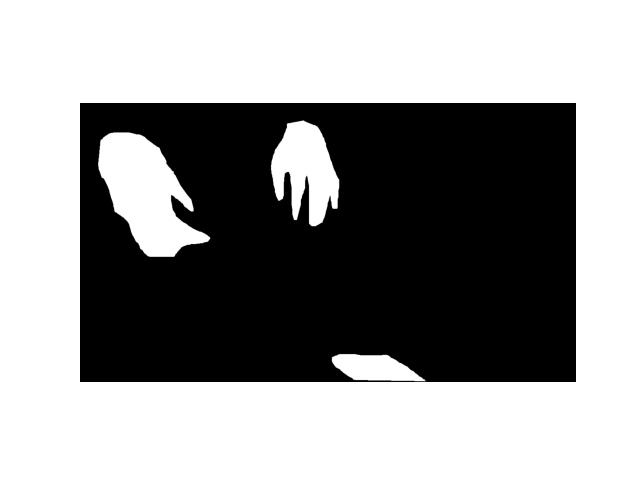

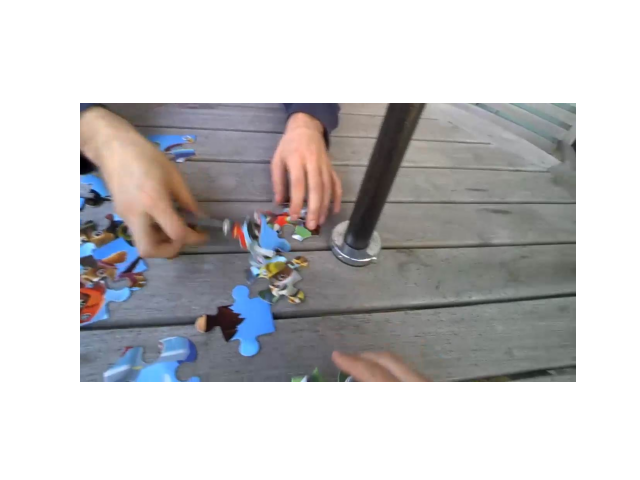

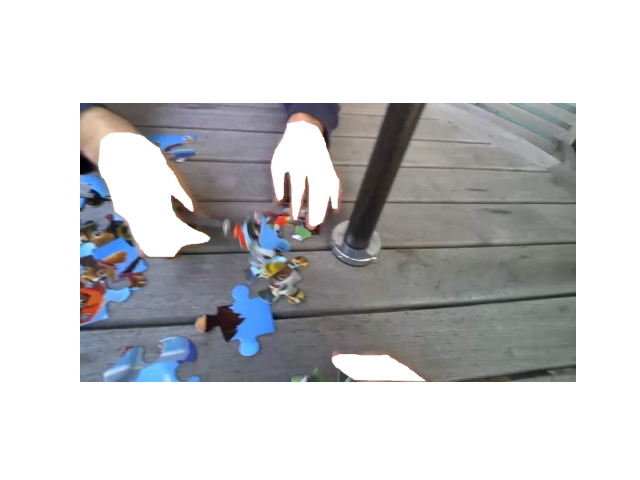

In [ ]:
# TEST segmentation masks, can be ignored
FRAME_NUM = 13

frame_name = labelled_frames[FRAME_NUM]['frame']
print(frame_name)

frame = get_labelled_frame(frame_name)
mask = get_segmentation_mask(frame)

plt.figure()
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

img = cv2.imread(f'images/{frame_name}.jpg')

plt.figure()
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

overlayed_img = img.copy()
overlayed_img[mask == 255] = (255, 255, 255)

plt.figure()
plt.imshow(overlayed_img[:,:,::-1])
plt.axis('off')
plt.show()


# Calculate dataset image statistics, identify features

In [251]:

# Given an image and a polygon extract [max, avg of minmax, min, avg of all] colors within the polygon using lightness channel in LAB or value channel in HSV
# indexes technically not required but was useful while testing
# requires to be ran
def get_colors(img, pts, color_space):
  if color_space == 'HSV':
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    masked_img_hsv = cv2.cvtColor(masked_img, cv2.COLOR_BGR2HSV)
    masked_pixels = masked_img_hsv[mask == 255]

    V_channel = masked_img_hsv[:, :, 2]
    V_channel_masked = V_channel[mask == 255]

    lightest_index = np.argmax(V_channel_masked)
    darkest_index = np.argmin(V_channel_masked)
    mask_coords = np.column_stack(np.where(mask == 255))

    lightest_coords = mask_coords[lightest_index]
    darkest_coords = mask_coords[darkest_index]

    lightest_color_hsv = masked_img_hsv[lightest_coords[0], lightest_coords[1]]
    darkest_color_hsv = masked_img_hsv[darkest_coords[0], darkest_coords[1]]

    mean_color_hsv = ((lightest_color_hsv.astype(np.int32) + darkest_color_hsv.astype(np.int32)) / 2).astype(np.uint8)
    mean_color_bgr = cv2.cvtColor(np.uint8([[mean_color_hsv]]), cv2.COLOR_HSV2BGR)[0][0]
    lightest_color_bgr = cv2.cvtColor(np.uint8([[lightest_color_hsv]]), cv2.COLOR_HSV2BGR)[0][0]
    darkest_color_bgr = cv2.cvtColor(np.uint8([[darkest_color_hsv]]), cv2.COLOR_HSV2BGR)[0][0]

    mean_overall = np.mean(masked_pixels, axis=0).astype(np.uint8)
    mean_overall_bgr = cv2.cvtColor(np.array([[mean_overall]]), cv2.COLOR_HSV2BGR)[0][0]

    return [lightest_color_bgr, mean_color_bgr, darkest_color_bgr, mean_overall_bgr]

  if color_space == 'LAB':
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    masked_img_lab = cv2.cvtColor(masked_img, cv2.COLOR_BGR2LAB)
    masked_pixels = masked_img_lab[mask == 255]

    L_channel = masked_img_lab[:, :, 0]
    L_channel_masked = L_channel[mask == 255]

    lightest_index = np.argmax(L_channel_masked)
    darkest_index = np.argmin(L_channel_masked)
    mask_coords = np.column_stack(np.where(mask == 255))

    lightest_coords = mask_coords[lightest_index]
    darkest_coords = mask_coords[darkest_index]

    lightest_color_lab = masked_img_lab[lightest_coords[0], lightest_coords[1]]
    darkest_color_lab = masked_img_lab[darkest_coords[0], darkest_coords[1]]

    mean_color_lab = ((lightest_color_lab.astype(np.int32) + darkest_color_lab.astype(np.int32)) / 2).astype(np.uint8)
    mean_color_bgr = cv2.cvtColor(np.uint8([[mean_color_lab]]), cv2.COLOR_Lab2BGR)[0][0]
    lightest_color_bgr = cv2.cvtColor(np.uint8([[lightest_color_lab]]), cv2.COLOR_Lab2BGR)[0][0]
    darkest_color_bgr = cv2.cvtColor(np.uint8([[darkest_color_lab]]), cv2.COLOR_Lab2BGR)[0][0]

    mean_overall = np.mean(masked_pixels, axis=0).astype(np.uint8)
    mean_overall_bgr = cv2.cvtColor(np.array([[mean_overall]]), cv2.COLOR_Lab2BGR)[0][0]

    return [lightest_color_bgr, mean_color_bgr, darkest_color_bgr, mean_overall_bgr]



# calculate interesting properties of the ground truth polygons - useful for comparing with detected contours
convex_hull_areas = []
polygon_areas = []
bbox_areas = []
solidities = [] # polygon area / convex hull area
extents = [] # polygon area / bbox area
aspect_ratios = [] # bbox width / bbox height
rectangularities = [] # bbox area / polygon area
colors = []

for labelled_frame in labelled_frames:
  _polygon_areas = []
  _convex_hull_areas = []
  _bbox_areas = []
  _aspect_ratios = []
  _colors = []

  for polygon in ['myleft', 'myright', 'yourleft', 'yourright']:
    if labelled_frame[polygon].shape != (1, 0):
      pts = np.array(labelled_frame[polygon], dtype=np.int32)

      hull = cv2.convexHull(pts)
      hull_area = cv2.contourArea(hull)
      _convex_hull_areas.append(hull_area)

      polygon_area = cv2.contourArea(pts)
      _polygon_areas.append(polygon_area)

      rect = cv2.minAreaRect(pts) # [[cx, cy], [w, h], [rotation]]
      box = cv2.boxPoints(rect)
      box = box.astype(np.int32)
      width, height = rect[1]

      aspect_ratio = width / height
      _aspect_ratios.append(aspect_ratio)

      bbox_area = width * height
      _bbox_areas.append(bbox_area)

      # extract color
      img = cv2.imread(f'images/{labelled_frame["frame"]}.jpg')
      poly_colors = get_colors(img, pts, 'LAB')
      _colors.append(poly_colors)

  _colors = np.array(_colors)
  # get average of all regions indicated - results in a single array of [[max_RGB], [minmax_avg_RGB], [min_RGB], [pixel_avg_RGB]]
  avg_colors = np.mean(_colors, axis=0).astype(np.uint8)
  colors.append(avg_colors)
  convex_hull_areas.append(_convex_hull_areas)
  polygon_areas.append(_polygon_areas)
  aspect_ratios.append(_aspect_ratios)
  bbox_areas.append(_bbox_areas)



# polygon area / convex hull area
for h_areas, p_areas in zip(convex_hull_areas, polygon_areas):
  _solidities = []

  for h_area, p_area in zip(h_areas, p_areas):
    _solidities.append(p_area / h_area)

  solidities.append(_solidities)

# polygon area / bbox area
# bbox area / polygon area
for bb_areas, p_areas in zip(bbox_areas, polygon_areas):
  _extents = []
  _rectangularities = []

  for bbox_area, p_area in zip(bb_areas, p_areas):
    _extents.append(p_area / bbox_area)
    _rectangularities.append(bbox_area / p_area)

  extents.append(_extents)
  rectangularities.append(_rectangularities)

# flatten all arrays so that mean can be calculated
flat_c_hull_areas = [x for xs in convex_hull_areas for x in xs]
flat_polygon_areas = [x for xs in polygon_areas for x in xs]
flat_solidities = [x for xs in solidities for x in xs]
flat_bbox_areas = [x for xs in bbox_areas for x in xs]
flat_extents = [x for xs in extents for x in xs]
flat_rectangularities = [x for xs in rectangularities for x in xs]
flat_aspect_ratios = [x for xs in aspect_ratios for x in xs]

colors = [c for c in colors if isinstance(c, np.ndarray)]
averaged_colors = np.mean(colors, axis=0).astype(np.uint8)
print(f'Average colors: {averaged_colors}')

features_obj = {
  'convex_hull_areas': convex_hull_areas,
  'polygon_areas': polygon_areas,
  'bbox_areas': bbox_areas,
  'solidities': solidities,
  'extents': extents,
  'rectangularities': rectangularities,
  'aspect_ratios': aspect_ratios,
  'avg_c_hull_area': np.mean(flat_c_hull_areas),
  'avg_polygon_area': np.mean(flat_polygon_areas),
  'avg_solidity': np.mean(flat_solidities),
  'avg_bbox_area': np.mean(flat_bbox_areas),
  'avg_extent': np.mean(flat_extents),
  'avg_rectangularity': np.mean(flat_rectangularities),
  'avg_aspect_ratio': np.mean(flat_aspect_ratios),
  'max_c_hull_area': np.max(flat_c_hull_areas),
  'max_polygon_area': np.max(flat_polygon_areas),
  'max_solidity': np.max(flat_solidities),
  'max_bbox_area': np.max(flat_bbox_areas),
  'max_extent': np.max(flat_extents),
  'max_rectangularity': np.max(flat_rectangularities),
  'max_aspect_ratio': np.max(flat_aspect_ratios),
  'min_c_hull_area': np.min(flat_c_hull_areas),
  'min_polygon_area': np.min(flat_polygon_areas),
  'min_solidity': np.min(flat_solidities),
  'min_bbox_area': np.min(flat_bbox_areas),
  'min_extent': np.min(flat_extents),
  'min_rectangularity': np.min(flat_rectangularities),
  'min_aspect_ratio': np.min(flat_aspect_ratios),
  'min_color_BGR': averaged_colors[2],
  'max_color_BGR': averaged_colors[0],
  'avg_minmax_color_BGR': averaged_colors[1],
  'avg_pixels_color_BGR': averaged_colors[3],
  'min_color_LAB': cv2.cvtColor(np.array([[averaged_colors[2]]]), cv2.COLOR_BGR2LAB)[0][0],
  'max_color_LAB': cv2.cvtColor(np.array([[averaged_colors[0]]]), cv2.COLOR_BGR2LAB)[0][0],
  'avg_minmax_color_LAB': cv2.cvtColor(np.array([[averaged_colors[1]]]), cv2.COLOR_BGR2LAB)[0][0],
  'avg_pixels_color_LAB': cv2.cvtColor(np.array([[averaged_colors[3]]]), cv2.COLOR_BGR2LAB)[0][0]
}

# normalize all features to a 0-1 range
def normalize_feature(value, feature_name):
  assert f'avg_{feature_name}' in features_obj, f'Feature {feature_name} not found'

  min_val = features_obj[f'min_{feature_name}']
  max_val = features_obj[f'max_{feature_name}']
  return (value - min_val) / (max_val - min_val)

# calculate features from the polygon specifying a detected contour
def detect_features(polygon, image):
  pts = np.array(polygon, dtype=np.int32)

  hull = cv2.convexHull(pts)
  hull_area = cv2.contourArea(hull)
  polygon_area = cv2.contourArea(pts)

  rect = cv2.minAreaRect(pts) # [[cx, cy], [w, h], [rotation]]
  box = cv2.boxPoints(rect)
  box = box.astype(np.int32)
  width, height = rect[1]
  aspect_ratio = width / height if height > 0 else 0
  bbox_area = width * height
  solidity = polygon_area / hull_area if hull_area > 0 else 0
  extent = polygon_area / bbox_area if bbox_area > 0 else 0
  rectangularity = bbox_area / polygon_area if polygon_area > 0 else 0

  img_mask = np.zeros(image.shape[:2], dtype=np.uint8)
  cv2.fillPoly(img_mask, [pts], 255)
  masked_img = cv2.bitwise_and(image, image, mask=img_mask)
  masked_pixels = masked_img[img_mask == 255]
  color = np.mean(masked_pixels, axis=0).astype(np.uint8)
  color = cv2.cvtColor(np.array([[color]]), cv2.COLOR_BGR2LAB)[0][0]

  return {
      'c_hull_area': hull_area,
      'polygon_area': polygon_area,
      'aspect_ratio': aspect_ratio,
      'bbox_area': bbox_area,
      'solidity': solidity,
      'extent': extent,
      'rectangularity': rectangularity,
      'color': color
  }


# TODO implement weights
def compute_score(detected_features):
  normalized_features = []

  for key, value in detected_features.items():
    normalized_value = normalize_feature(value, key)
    normalized_features.append(normalized_value)

  distance = np.linalg.norm(np.array(normalized_features) - np.array(hand_descriptors))
  return distance

def compute_score_weighted(detected_features, weights):
  normalized_features = []

  for key, value in detected_features.items():

    if key == 'color':
      normalized_value = normalize_color(value)
      normalized_features.extend(normalized_value)
      # print('normalized color: ', normalized_value)
    else:
      normalized_value = normalize_feature(value, key)
      normalized_features.append(normalized_value)


  # print('normalized features', normalized_features)
  # print('hand_descriptors', hand_descriptors)
  differences = np.absolute(np.array(normalized_features) - np.array(hand_descriptors))
  weighted_differences = differences * np.array(weights)
  score = np.sum(weighted_differences)

  return 1 / (1 + score)

# calculate a single descriptor vector from all of the ground truth averages
hand_descriptors = [normalize_feature(value, key[4:]) for key, value in features_obj.items() if 'avg' in key and 'color' not in key]

# handle colors separately on per channel basis
# (value - min_val) / (max_val - min_val)
def normalize_color(color):
  L, A, B = color
  return [L / 255, A / 255, B / 255]



# (min + max) / 2
# avg_minmax = features_obj['avg_minmax_color_LAB']
avg_pixels = features_obj['avg_pixels_color_LAB']
# hand_descriptors.extend(normalize_color(avg_minmax))
hand_descriptors.extend(normalize_color(avg_pixels))

for key, value in features_obj.items():
  if key not in ('convex_hull_areas', 'polygon_areas', 'ratios', 'bbox_areas', 'solidities', 'rectangularities', 'aspect_ratios', 'extents'):
    print(f'{key}: {value}')

print(hand_descriptors)



Average colors: [[193 205 230]
 [103 112 136]
 [ 24  30  52]
 [121 140 181]]
avg_c_hull_area: 25324.49090909091
avg_polygon_area: 22332.19090909091
avg_solidity: 0.883658953265415
avg_bbox_area: 33494.06394202588
avg_extent: 0.66433541554065
avg_rectangularity: 1.5366056880260412
avg_aspect_ratio: 1.325095989625776
max_c_hull_area: 61614.5
max_polygon_area: 54356.0
max_solidity: 0.9885022462499048
max_bbox_area: 81552.0159127973
max_extent: 0.7879332007500139
max_rectangularity: 3.210001107385024
max_aspect_ratio: 4.6705964686379255
min_c_hull_area: 1942.0
min_polygon_area: 1535.5
min_solidity: 0.4576816796285218
min_bbox_area: 2414.0
min_extent: 0.3115263722804862
min_rectangularity: 1.269143119046291
min_aspect_ratio: 0.11971830985915492
min_color_BGR: [24 30 52]
max_color_BGR: [193 205 230]
avg_minmax_color_BGR: [103 112 136]
avg_pixels_color_BGR: [121 140 181]
min_color_LAB: [ 36 138 136]
max_color_LAB: [215 135 137]
avg_minmax_color_LAB: [126 136 136]
avg_pixels_color_LAB: [157 14

# Helper methods

In [250]:
# requires to be ran

# non recursive BFS to merge contours based on euclidean distance of their centroids
# centroids calculated using moments: https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html
def merge_contours(contours, distance):
  merged_contours = []
  visited = set()  # To track processed contours

  def are_close(cnt1, cnt2):
    moments1 = cv2.moments(cnt1)
    moments2 = cv2.moments(cnt2)
    if moments1['m00'] == 0 or moments2['m00'] == 0:
      return False

    cx1 = int(moments1['m10'] / moments1['m00'])
    cy1 = int(moments1['m01'] / moments1['m00'])
    cx2 = int(moments2['m10'] / moments2['m00'])
    cy2 = int(moments2['m01'] / moments2['m00'])

    return np.linalg.norm(np.array([cx1, cy1]) - np.array([cx2, cy2])) < distance

  def merge_group(group):
    all_points = np.vstack(group)
    return cv2.convexHull(all_points)

  for i, contour in enumerate(contours):
    if i in visited:
        continue

    group = [contour]
    visited.add(i)
    for j, other_contour in enumerate(contours):
        if j in visited:
            continue
        if any(are_close(c, other_contour) for c in group):
            group.append(other_contour)
            visited.add(j)

    merged_contours.append(merge_group(group))

  return merged_contours

# use L2 distance in LAB color space to determine wether pixels should be in the mask or not
def in_range(img, color, cutoff):
  img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  distances = np.linalg.norm(img_lab - color, axis=-1)
  mask = (distances < cutoff).astype(np.uint8) * 255
  return mask

# convert BGR color into HSV, attempt to calculate lower and upper tones of the same color
def calculate_color_bounds(color):
  color = cv2.cvtColor(np.array([[color]]), cv2.COLOR_BGR2HSV)[0][0]

  min_hsv = color.copy()
  min_hsv[2] = 100
  min_hsv[1] *= 1.3
  min_hsv = np.clip(min_hsv, 0, 255).astype(np.uint8)

  max_hsv = color.copy()
  max_hsv[2] = 245
  max_hsv[1] *= 0.7
  max_hsv = np.clip(max_hsv, 0, 255).astype(np.uint8)

  min_bgr = cv2.cvtColor(np.array([[min_hsv]]), cv2.COLOR_HSV2BGR)[0][0]
  max_bgr = cv2.cvtColor(np.array([[max_hsv]]), cv2.COLOR_HSV2BGR)[0][0]
  return [min_bgr, max_bgr]

# attempt to find closest color within an image using L2 distance
def find_closest_color(img, color):
  img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  distances = np.linalg.norm(img_lab - color, axis=-1)
  min_distance = np.min(distances)
  closest_pixel_indices = np.unravel_index(np.argmin(distances), distances.shape)
  closest_color = img[closest_pixel_indices]

  return [closest_color, closest_pixel_indices, min_distance]

# Color space testing, testing of color based segmentation, testing of contour reconstruction/merging based on centroid distance

frame_0365
[array([182, 199, 255], dtype=uint8), array([116, 124, 168], dtype=uint8), array([55, 57, 91], dtype=uint8), array([128, 147, 201], dtype=uint8)]
[array([175, 188, 255], dtype=uint8), array([112, 118, 173], dtype=uint8), array([55, 57, 91], dtype=uint8), array([127, 154, 202], dtype=uint8)]


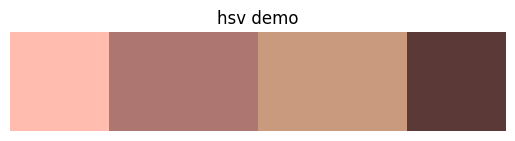

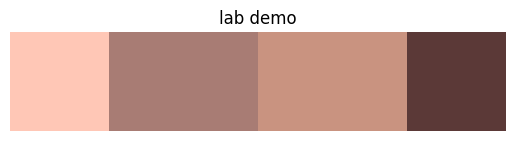

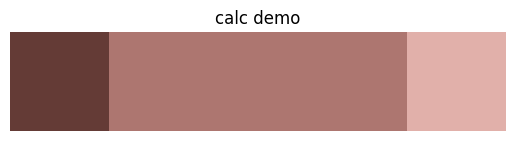

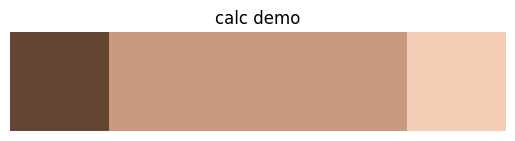

In [110]:
# a lot of testing here, can be ignored

plt.close('all')
img_name = labelled_frames[15]['frame']
pts = np.array(labelled_frames[15]['yourleft'], dtype=np.int32)
# print(pts)
print(img_name)

lab_colors = get_colors(cv2.imread(f'images/{img_name}.jpg'), pts, 'LAB')
hsv_colors = get_colors(cv2.imread(f'images/{img_name}.jpg'), pts, 'HSV')

print(lab_colors)
print(hsv_colors)

color_demo_hsv = np.zeros((2, 10, 3), dtype=np.uint8)
color_demo_hsv[:, 2:5] = hsv_colors[1]
color_demo_hsv[:, 5:] = hsv_colors[3]
color_demo_hsv[:,:2] = hsv_colors[0]
color_demo_hsv[:,8:] = hsv_colors[2]

plt.figure()
plt.imshow(color_demo_hsv[:,:,::-1])
plt.title('hsv demo')
plt.axis('off')
plt.show()

color_demo_lab = np.zeros((2, 10, 3), dtype=np.uint8)
color_demo_lab[:, 2:5] = lab_colors[1]
color_demo_lab[:, 5:] = lab_colors[3]
color_demo_lab[:,:2] = lab_colors[0]
color_demo_lab[:,8:] = lab_colors[2]

plt.figure()
plt.imshow(color_demo_lab[:,:,::-1])
plt.title('lab demo')
plt.axis('off')
plt.show()

# calc colors from averages 1, 3
avg_hsv1 = cv2.cvtColor(np.array([[hsv_colors[1]]]), cv2.COLOR_BGR2HSV)[0][0]
avg_hsv2 = cv2.cvtColor(np.array([[hsv_colors[3]]]), cv2.COLOR_BGR2HSV)[0][0]

min_hsv1 = avg_hsv1.copy()
min_hsv1[2] = 100
min_hsv1[1] *= 1.3
min_hsv1 = np.clip(min_hsv1, 0, 255).astype(np.uint8)
max_hsv1 = avg_hsv1.copy()
max_hsv1[2] = 225
max_hsv1[1] *= 0.7
max_hsv1 = np.clip(max_hsv1, 0, 255).astype(np.uint8)
min_hsv1 = cv2.cvtColor(np.uint8([[min_hsv1]]), cv2.COLOR_HSV2BGR)[0][0]
max_hsv1 = cv2.cvtColor(np.uint8([[max_hsv1]]), cv2.COLOR_HSV2BGR)[0][0]
avg_hsv1 = cv2.cvtColor(np.uint8([[avg_hsv1]]), cv2.COLOR_HSV2BGR)[0][0]

color_demo_calc = np.zeros((2, 10, 3), dtype=np.uint8)
color_demo_calc[:,:,:] = avg_hsv1
color_demo_calc[:, :2] = min_hsv1
color_demo_calc[:, 8:] = max_hsv1

plt.figure()
plt.imshow(color_demo_calc[:,:,::-1])
plt.title('calc demo')
plt.axis('off')
plt.show()

min_hsv2 = avg_hsv2.copy()
min_hsv2[2] = 100
min_hsv2[1] *= 1.3
min_hsv2 = np.clip(min_hsv2, 0, 255).astype(np.uint8)
max_hsv2 = avg_hsv2.copy()
max_hsv2[2] = 245
max_hsv2[1] *= 0.7
max_hsv2 = np.clip(max_hsv2, 0, 255).astype(np.uint8)
min_hsv2 = cv2.cvtColor(np.uint8([[min_hsv2]]), cv2.COLOR_HSV2BGR)[0][0]
max_hsv2 = cv2.cvtColor(np.uint8([[max_hsv2]]), cv2.COLOR_HSV2BGR)[0][0]
avg_hsv2 = cv2.cvtColor(np.uint8([[avg_hsv2]]), cv2.COLOR_HSV2BGR)[0][0]

color_demo_calc2 = np.zeros((2, 10, 3), dtype=np.uint8)
color_demo_calc2[:,:,:] = avg_hsv2
color_demo_calc2[:, :2] = min_hsv2
color_demo_calc2[:, 8:] = max_hsv2

plt.figure()
plt.imshow(color_demo_calc2[:,:,::-1])
plt.title('calc demo')
plt.axis('off')
plt.show()



frame_0009
[[403 709]
 [403 710]
 [403 711]
 ...
 [515 710]
 [515 711]
 [515 712]]
[435 653]
[444 763]
[226 138 145]
[ 30 138 136]
Lightest color (BGR): [191 215 254]
Darkest color (BGR): [20 25 47]


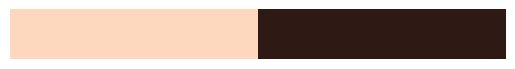

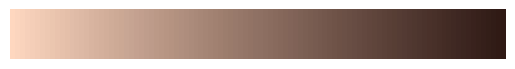

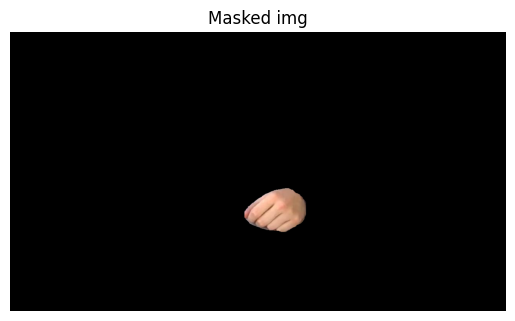

[20 25 47]
[191 215 254]


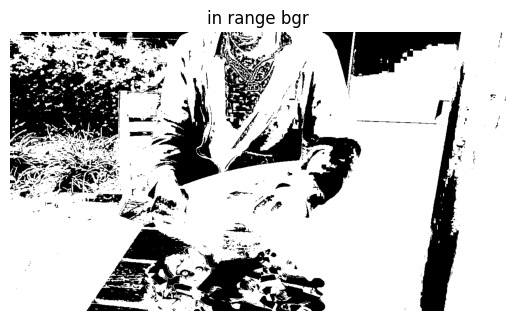

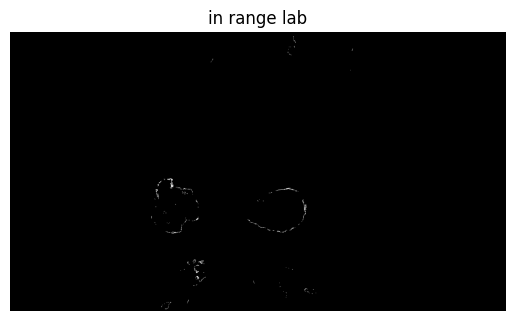

lightest hsv: [ 11  63 254]
darkest hsv: [  6 146  47]
lightest hsv: [ 11 146 254]
darkest hsv: [ 6 63 47]
24275
4
2


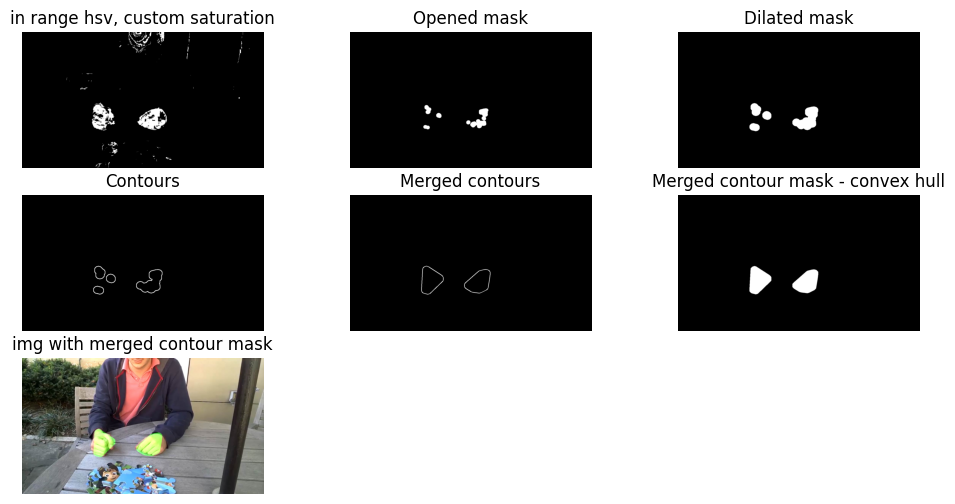

In [9]:
# more color space testing, contour merging testing, can be ignored
plt.close('all')

img_name = labelled_frames[0]['frame']
pts = np.array(labelled_frames[0]['yourleft'], dtype=np.int32)
# print(pts)
print(img_name)

img = cv2.imread(f'images/{img_name}.jpg')
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask, [pts], 255)
masked_img = cv2.bitwise_and(img, img, mask=mask)
masked_img_lab = cv2.cvtColor(masked_img, cv2.COLOR_BGR2LAB)

L_channel = masked_img_lab[:, :, 0]
L_channel_masked = L_channel[mask == 255]

lightest_index = np.argmax(L_channel_masked)
darkest_index = np.argmin(L_channel_masked)

# Get all the coordinates of the mask
mask_coords = np.column_stack(np.where(mask == 255))
print(mask_coords)

lightest_coords = mask_coords[lightest_index]
darkest_coords = mask_coords[darkest_index]

print(lightest_coords)
print(darkest_coords)

lightest_color_lab = masked_img_lab[lightest_coords[0], lightest_coords[1]]
darkest_color_lab = masked_img_lab[darkest_coords[0], darkest_coords[1]]

print(lightest_color_lab)
print(darkest_color_lab)

lightest_color_bgr = cv2.cvtColor(np.uint8([[lightest_color_lab]]), cv2.COLOR_Lab2BGR)[0][0]
darkest_color_bgr = cv2.cvtColor(np.uint8([[darkest_color_lab]]), cv2.COLOR_Lab2BGR)[0][0]

print(f'Lightest color (BGR): {lightest_color_bgr}')
print(f'Darkest color (BGR): {darkest_color_bgr}')

# Show min and max skin tone
colors_demo = np.zeros((10, 100, 3), dtype=np.uint8)
colors_demo[:, :50] = lightest_color_bgr
colors_demo[:, 50:] = darkest_color_bgr

plt.figure()
plt.imshow(colors_demo[:,:,::-1])
plt.axis('off')
plt.show()

# show a gradient of colors between min and max color
num_colors = 100  # Number of steps in the gradient
lab_gradient = np.linspace(lightest_color_lab, darkest_color_lab, num_colors).astype(np.uint8)

bgr_gradient = cv2.cvtColor(lab_gradient[np.newaxis, :, :], cv2.COLOR_Lab2BGR)
bgr_gradient_resized = cv2.resize(bgr_gradient, (100, 10), interpolation=cv2.INTER_LINEAR)

# Display the gradient bar
plt.figure()
plt.imshow(bgr_gradient_resized[:, :, ::-1])  # Convert BGR to RGB for matplotlib
plt.axis('off')
plt.show()


plt.figure()
plt.title('Masked img')
plt.imshow(masked_img[:,:,::-1])
plt.axis('off')
plt.show()

lower_bound = cv2.cvtColor(np.uint8([[darkest_color_lab]]), cv2.COLOR_Lab2BGR)[0][0]
upper_bound = cv2.cvtColor(np.uint8([[lightest_color_lab]]), cv2.COLOR_Lab2BGR)[0][0]

print(lower_bound)
print(upper_bound)
mask = cv2.inRange(img, lower_bound, upper_bound)

plt.figure()
plt.title('in range bgr')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

mask_lab = cv2.inRange(img_lab, darkest_color_lab, lightest_color_lab)

plt.figure()
plt.title('in range lab')
plt.imshow(mask_lab, cmap='gray')
plt.axis('off')
plt.show()

lower_bound_hsv = cv2.cvtColor(np.uint8([[darkest_color_bgr]]), cv2.COLOR_BGR2HSV)[0][0]
upper_bound_hsv = cv2.cvtColor(np.uint8([[lightest_color_bgr]]), cv2.COLOR_BGR2HSV)[0][0]

print(f'lightest hsv: {upper_bound_hsv}')
print(f'darkest hsv: {lower_bound_hsv}')

# lower_bound_hsv[0] = 0
# upper_bound_hsv[0] = 25
lower_bound_hsv[1] = 63
upper_bound_hsv[1] = 146

print(f'lightest hsv: {upper_bound_hsv}')
print(f'darkest hsv: {lower_bound_hsv}')

img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask_hsv = cv2.inRange(img_hsv, lower_bound_hsv, upper_bound_hsv)
print(np.count_nonzero(mask_hsv))

plt.figure(figsize=(12, 6))
plt.subplot(3, 3, 1)
plt.title('in range hsv, custom saturation')
plt.imshow(mask_hsv, cmap='gray')
plt.axis('off')

opened_mask = cv2.morphologyEx(mask_hsv, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)))
dilated_mask = cv2.dilate(opened_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)))

plt.subplot(3, 3, 2)
plt.title('Opened mask')
plt.imshow(opened_mask, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.title('Dilated mask')
plt.imshow(dilated_mask, cmap='gray')
plt.axis('off')

contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt_img = np.zeros_like(dilated_mask)
cv2.drawContours(cnt_img, contours, -1, 255, 2)

plt.subplot(3, 3, 4)
plt.title('Contours')
plt.imshow(cnt_img, cmap='gray')
plt.axis('off')

print(len(contours))


# merge contours based on distance between centroids
min_distance = 150
merged_contours = []

def merge_contours(contours, distance):
    merged_contours = []
    visited = set()  # To track processed contours

    def are_close(cnt1, cnt2):
        moments1 = cv2.moments(cnt1)
        moments2 = cv2.moments(cnt2)
        if moments1['m00'] == 0 or moments2['m00'] == 0:
            return False

        cx1 = int(moments1['m10'] / moments1['m00'])
        cy1 = int(moments1['m01'] / moments1['m00'])
        cx2 = int(moments2['m10'] / moments2['m00'])
        cy2 = int(moments2['m01'] / moments2['m00'])

        return np.linalg.norm(np.array([cx1, cy1]) - np.array([cx2, cy2])) < distance

    def merge_group(group):
        all_points = np.vstack(group)
        return cv2.convexHull(all_points)

    for i, contour in enumerate(contours):
        if i in visited:
            continue

        group = [contour]
        visited.add(i)
        for j, other_contour in enumerate(contours):
            if j in visited:
                continue
            if any(are_close(c, other_contour) for c in group):
                group.append(other_contour)
                visited.add(j)

        merged_contours.append(merge_group(group))

    return merged_contours

merged_contours = merge_contours(contours, min_distance)

merged_contour_image = np.zeros_like(dilated_mask)
cv2.drawContours(merged_contour_image, merged_contours, -1, 255, 2)

plt.subplot(3, 3, 5)
plt.title('Merged contours')
plt.imshow(merged_contour_image, cmap='gray')
plt.axis('off')

print(len(merged_contours))

contour_mask = np.zeros_like(dilated_mask)

for contour in merged_contours:
  convex_hull = cv2.convexHull(contour)
  mask = cv2.fillPoly(contour_mask, [convex_hull], 255)

plt.subplot(3, 3, 6)
plt.imshow(contour_mask, cmap='gray')
plt.title('Merged contour mask - convex hull')
plt.axis('off')

img_cpy = img.copy().astype(np.float32)
img_cpy[contour_mask == 255] += [0, 125, 0]
img_cpy = np.clip(img_cpy, 0, 255).astype(np.uint8)

plt.subplot(3, 3, 7)
plt.title('img with merged contour mask')
plt.imshow(img_cpy[:,:,::-1])
plt.axis('off')
plt.show()



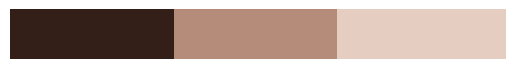

[ 6 41 52]
[ 10 137 230]
2


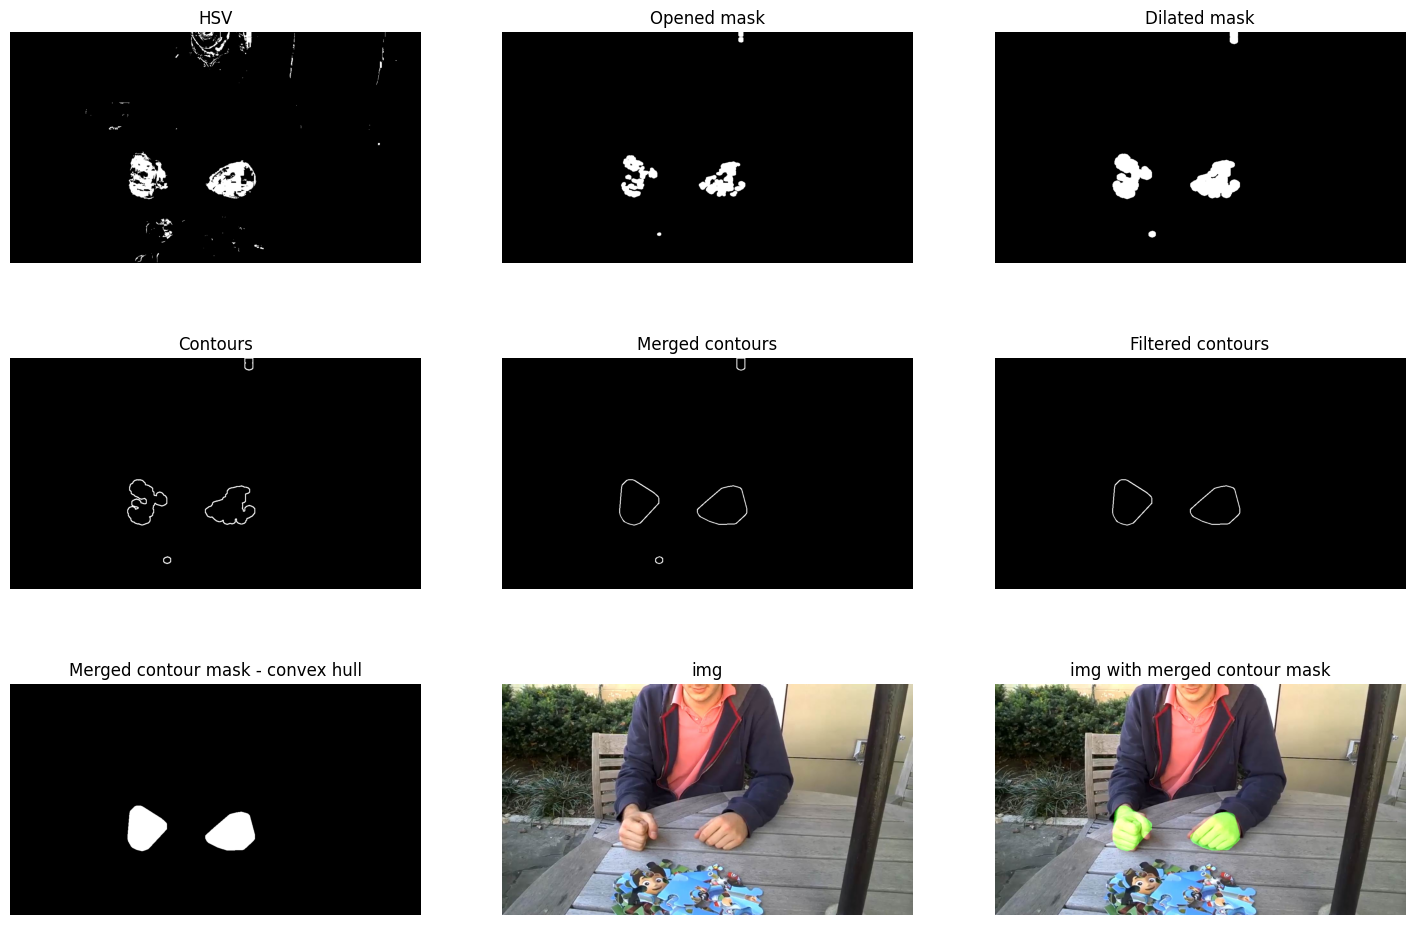

In [195]:
# can be ignored

# some more testing similar to the cell above
# it is using colors detected from the ground truth however

plt.close('all')
img_name = labelled_frames[0]['frame']
img = cv2.imread(f'images/{img_name}.jpg')
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_bound_LAB = features_obj['min_color_LAB']
upper_bound_LAB = features_obj['max_color_LAB']
avg_LAB = features_obj['avg_pixels_color_LAB']

lower_bound_BGR = features_obj['min_color_BGR']
upper_bound_BGR = features_obj['max_color_BGR']
avg_BGR = features_obj['avg_pixels_color_BGR']

lower_bound_HSV = cv2.cvtColor(np.array([[lower_bound_BGR]]), cv2.COLOR_BGR2HSV)[0][0]
upper_bound_HSV = cv2.cvtColor(np.array([[upper_bound_BGR]]), cv2.COLOR_BGR2HSV)[0][0]
avg_HSV = cv2.cvtColor(np.array([[avg_BGR]]), cv2.COLOR_BGR2HSV)[0][0]

# display average colors
colors_demo = np.zeros((10, 100, 3), dtype=np.uint8)
colors_demo[:,:,:] = avg_BGR
colors_demo[:,:33] = lower_bound_BGR
colors_demo[:,66:] = upper_bound_BGR

plt.figure()
plt.imshow(colors_demo[:,:,::-1])
plt.axis('off')
plt.show()

# inRange testing using extracted avg values


# lower_bound_HSV[0] = 0
# upper_bound_HSV[0] = 25
lower_bound_HSV[1] = 41
upper_bound_HSV[1] = 137

print(lower_bound_HSV)
print(upper_bound_HSV)

# Define the HSV range for skin detection
lower_skin = np.array([0, 50, 80])    # Lower bound of HSV for skin
upper_skin = np.array([20, 255, 255])  # Upper bound of HSV for skin

# print(lower_bound_LAB)
# print(upper_bound_LAB)

upper_bound_LAB[1] = 143
lower_bound_LAB[1] = 130
upper_bound_LAB[2] = 142
lower_bound_LAB[2] = 131
lower_bound_LAB[0] = 100
upper_bound_LAB[0] = 225

# lightest hsv: [ 11 146 254]
# darkest hsv: [ 6 63 47]
lower_bound_HSV = np.array([6, 63, 47])
upper_bound_HSV = np.array([11, 146, 254])

mask_LAB = cv2.inRange(img_lab, lower_bound_LAB, upper_bound_LAB)
mask_HSV = cv2.inRange(img_hsv, lower_bound_HSV, upper_bound_HSV)

plt.figure(figsize=(18, 12))
plt.subplot(3, 3, 1)
plt.title('HSV')
plt.imshow(mask_HSV, cmap='gray')
plt.axis('off')


opened_mask = cv2.morphologyEx(mask_HSV, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11)))
dilated_mask = cv2.dilate(opened_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11)))

plt.subplot(3, 3, 2)
plt.title('Opened mask')
plt.imshow(opened_mask, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.title('Dilated mask')
plt.imshow(dilated_mask, cmap='gray')
plt.axis('off')

contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt_img = np.zeros_like(dilated_mask)
cv2.drawContours(cnt_img, contours, -1, 255, 2)

plt.subplot(3, 3, 4)
plt.title('Contours')
plt.imshow(cnt_img, cmap='gray')
plt.axis('off')

min_distance = 100
merged_contours = merge_contours(contours, min_distance)

merged_contour_image = np.zeros_like(dilated_mask)
cv2.drawContours(merged_contour_image, merged_contours, -1, 255, 2)

plt.subplot(3, 3, 5)
plt.title('Merged contours')
plt.imshow(merged_contour_image, cmap='gray')
plt.axis('off')

min_area = features_obj['avg_polygon_area'] * 0.3
filtered_contours = [cnt for cnt in merged_contours if cv2.contourArea(cnt) > min_area]
filtered_cnt_img = np.zeros_like(dilated_mask)
cv2.drawContours(filtered_cnt_img, filtered_contours, -1, 255, 2)

plt.subplot(3, 3, 6)
plt.title('Filtered contours')
plt.imshow(filtered_cnt_img, cmap='gray')
plt.axis('off')

print(len(filtered_contours))


contour_mask = np.zeros_like(dilated_mask)
for contour in filtered_contours:
  convex_hull = cv2.convexHull(contour)
  mask = cv2.fillPoly(contour_mask, [convex_hull], 255)

plt.subplot(3, 3, 7)
plt.imshow(contour_mask, cmap='gray')
plt.title('Merged contour mask - convex hull')
plt.axis('off')

plt.subplot(3,3,8)
plt.imshow(img[:,:,::-1])
plt.title('img')
plt.axis('off')

img_cpy = img.copy().astype(np.float32)
img_cpy[contour_mask == 255] += [0, 125, 0]
img_cpy = np.clip(img_cpy, 0, 255).astype(np.uint8)

plt.subplot(3, 3, 9)
plt.title('img with merged contour mask')
plt.imshow(img_cpy[:,:,::-1])
plt.axis('off')
plt.show()



plt.show()




# Image preprocessing methods

In [286]:
# Image preprocessing methods, requires to be ran
# Color correction methods

def adaptive_eq_hist(img):
  # create a CLAHE object (Arguments are optional).
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  return clahe.apply(img)

def colored_eq_hist(img):
  ycrcb_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
  equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
  return equalized_img

def enhance_image(image):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  value_channel = hsv_image[:,:,2]
  eq_value_channel = cv2.equalizeHist(value_channel)
  hsv_image[:,:,2] = eq_value_channel
  enhanced_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
  return enhanced_image

def posterize(img, k, custom_centers=None):
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)

  if custom_centers is not None:
    ret, labels, centers = cv2.kmeans(img.reshape((-1, 3)).astype(np.float32), k, None, criteria, 10, cv2.KMEANS_PP_CENTERS, custom_centers)
  else:
    ret, labels, centers = cv2.kmeans(img.reshape((-1, 3)).astype(np.float32), k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

  centers = centers.astype(np.uint8)
  result = centers[labels.flatten()]
  result = result.reshape((img.shape))

  return result

# Image preprocessing tests

frame_0359


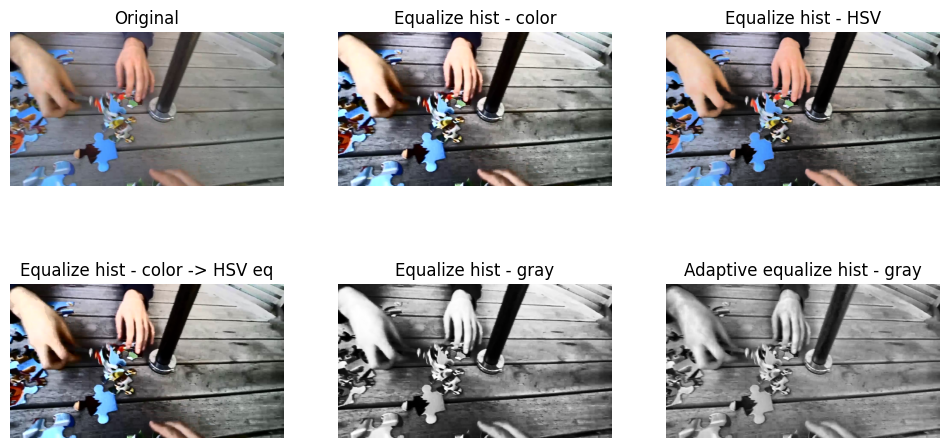

In [12]:
# various methods for color enhacement, can be ignored
FRAME_NUM = 13

frame_name = labelled_frames[FRAME_NUM]['frame']
print(frame_name)

img = cv2.imread(f'images/{frame_name}.jpg')

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.title('Original')
plt.imshow(img[:,:,::-1])
plt.axis('off')

equalized_ycrcb = colored_eq_hist(img)

plt.subplot(2, 3, 2)
plt.title('Equalize hist - color')
plt.imshow(equalized_ycrcb[:,:,::-1])
plt.axis('off')

enhanced = enhance_image(img)

plt.subplot(2, 3, 3)
plt.title('Equalize hist - HSV')
plt.imshow(enhanced[:,:,::-1])
plt.axis('off')

enhanced_equalized_ycrcb = enhance_image(equalized_ycrcb)

plt.subplot(2, 3, 4)
plt.title('Equalize hist - color -> HSV eq')
plt.imshow(enhanced_equalized_ycrcb[:,:,::-1])
plt.axis('off')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equalized_gray = cv2.equalizeHist(gray)

plt.subplot(2, 3, 5)
plt.title('Equalize hist - gray')
plt.imshow(equalized_gray, cmap='gray')
plt.axis('off')

equalized_adaptive_gray = adaptive_eq_hist(gray)

plt.subplot(2, 3, 6)
plt.title('Adaptive equalize hist - gray')
plt.imshow(equalized_adaptive_gray, cmap='gray')
plt.axis('off')
plt.show()

to_test = [
    (img, 'original'),
    (equalized_ycrcb, 'equalized_ycrcb'),
    (enhanced, 'enhanced'),
    (enhanced_equalized_ycrcb, 'enhanced_equalized_ycrcb'),
    (equalized_gray, 'equalized_gray'),
    (equalized_adaptive_gray, 'equalized_adaptive_gray')
  ]

# K-means segmentation tests

frame_0105


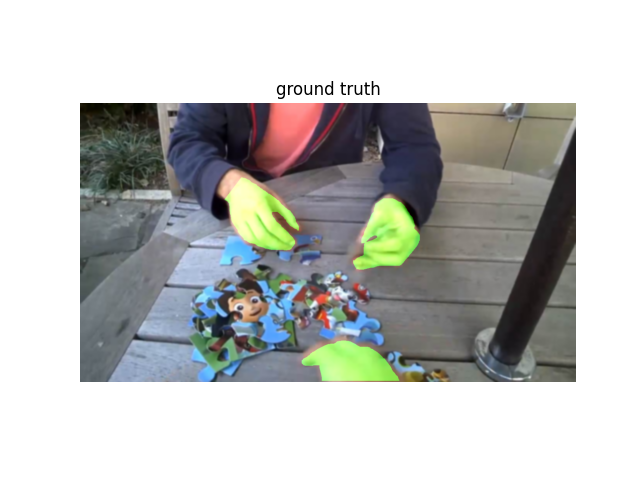

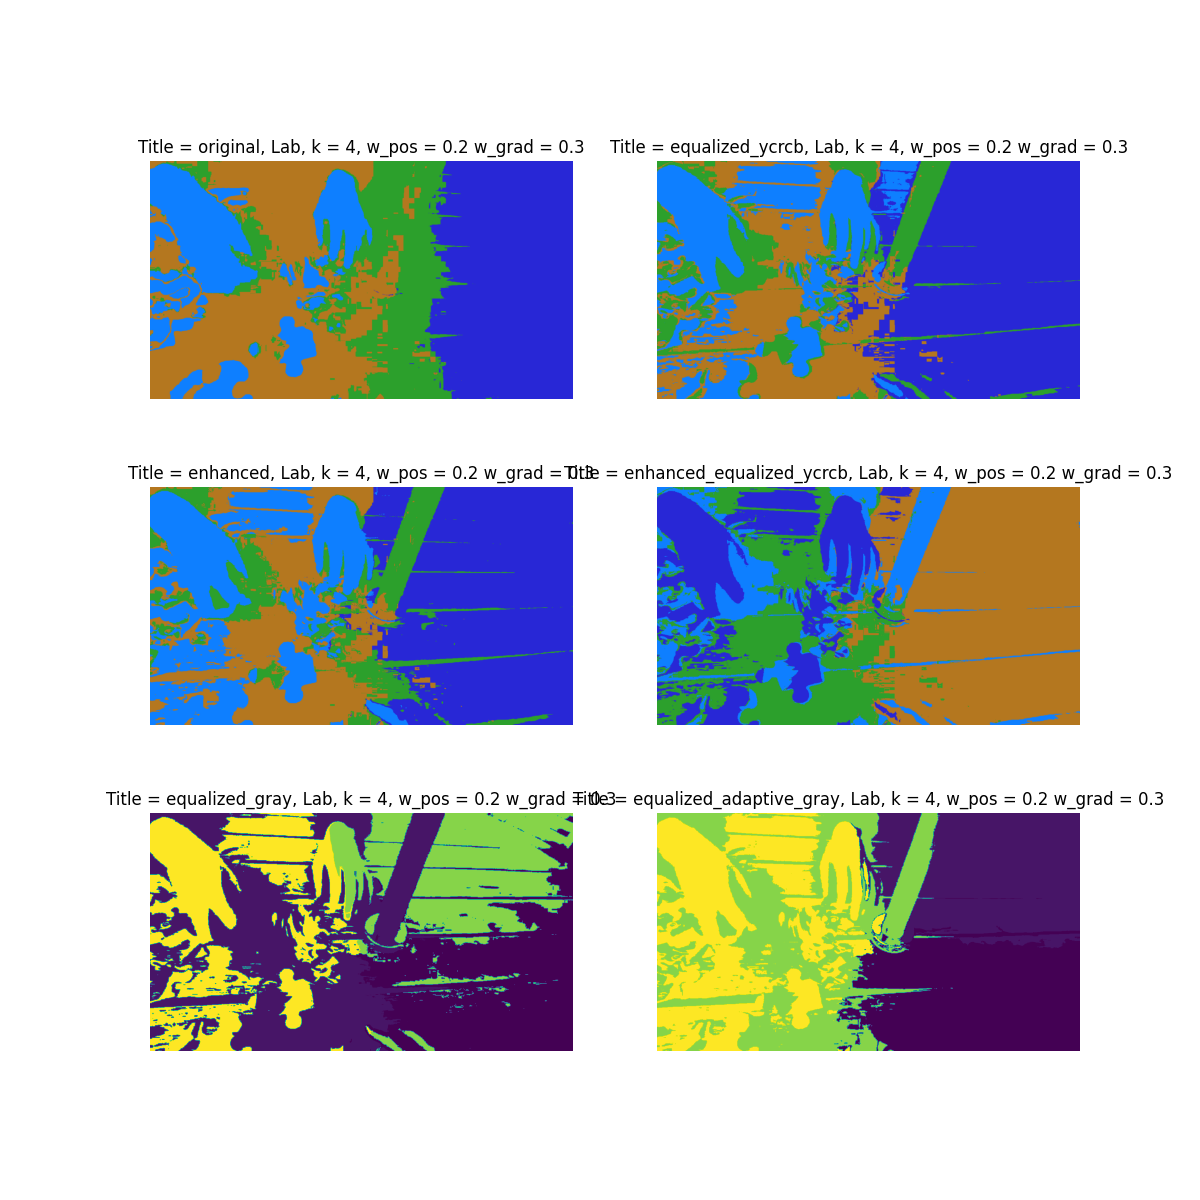

In [ ]:
# K-means segmentation testing, can be ignored

def segment_k_means(img, k, conversion=None, position_w=0, gradient_w=0):
  original_img = img.copy()

  if conversion is not None and len(img.shape) == 3:
    img = cv2.cvtColor(img, conversion)

  img = img.astype(np.float32)

  h, w = img.shape[:2]
  # print(h, w)

  pixels = img.reshape((h * w, -1))

  if position_w > 0:
    x, y = np.meshgrid(range(w), range(h))
    x = x.reshape(h * w)
    y = y.reshape(h * w)
    positions = np.column_stack([x, y]).astype(np.float32)
    pixels = np.column_stack((pixels, position_w * positions))

  if gradient_w > 0:
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY) if len(original_img.shape) == 3 else img
    grad_x = cv2.Sobel(gray_img, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_img, cv2.CV_32F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    gradients = gradient_w * gradient_magnitude.flatten()[:, None]
    pixels = np.column_stack((pixels, gradients))


  # pixel_shape = pixels.shape
  # print(pixels[pixel_shape[0]//2:pixel_shape[0]//2+20])

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)

  # Reshape the labels to match the original image shape
  segmentation = labels.reshape((h, w))

  return segmentation

def label_overlay(img, labels):
  k = np.max(labels) + 1
  cmap = plt.get_cmap('tab10')  # You can choose a different colormap if needed
  h, w = img.shape[:2]

  if len(img.shape) == 3:
    overlay = np.zeros((h, w, 3), dtype=np.uint8)
  else:  # If image is grayscale
    overlay = np.zeros((h, w), dtype=np.uint8)

  for label in range(k):
    color = np.array(cmap(label)[:3]) * 255

    if len(img.shape) == 2:
      color = color[0]

    overlay[labels == label] = color

  # Combine the image and overlay
  # output = cv2.addWeighted(img, 1.0, overlay, 0.5, 0)
  # return output

  return overlay


FRAME_NUM = 3

frame_name = labelled_frames[FRAME_NUM]['frame']
print(frame_name)

frame = get_labelled_frame(frame_name)
mask = get_segmentation_mask(frame)
img = cv2.imread(f'images/{frame_name}.jpg')

# apply gaussian
img = cv2.GaussianBlur(img, (9, 9), 0)

masked_img = img.copy()
masked_img = masked_img.astype(np.float32)
masked_img[mask == 255] += [0, 125, 0]
masked_img = np.clip(masked_img, 0, 255)
masked_img = masked_img.astype(np.uint8)

plt.figure()
plt.imshow(masked_img[:,:,::-1])
plt.title('ground truth')
plt.axis('off')
plt.show()

k = 4
pw = 0.2
gw = 0.3

plt.figure(figsize=(12, 12))

for i, (img, title) in enumerate(to_test):
  overlayed = label_overlay(img, segment_k_means(img, k, cv2.COLOR_BGR2HSV, position_w=pw, gradient_w=gw))
  if len(overlayed.shape) == 3:
    overlayed = overlayed[:, :, ::-1]

  plt.subplot(3, 2, i+1)
  plt.imshow(overlayed)

  plt.title(f'Title = {title}, Lab, k = {k}, w_pos = {pw} w_grad = {gw}')
  plt.axis("off")

plt.show()



# Image preprocessing using posterize + Color based segmentation

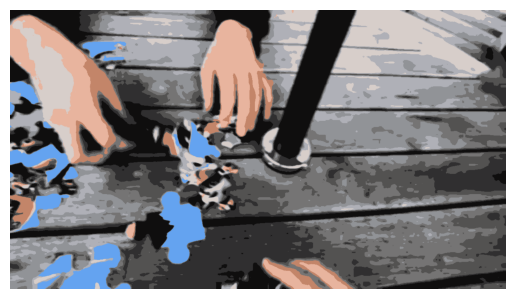

11

In [ ]:
# testing of image preprocessing
# can be ignored, mouse click interactivity no longer works because of some update

def detect_skin(img, lower_bound, upper_bound):
  mask = cv2.inRange(img, lower_bound, upper_bound)
  return mask

# click to select the lower/upper skin color bounds
def onclick(event):
  global buff, color_space, img_axes
  ix, iy = event.xdata, event.ydata

  if ix is None or iy is None:
    return

  # print(ix, iy)
  # print(converted_img[int(iy), int(ix)])
  buff.append(converted_img[int(iy), int(ix)])

  if len(buff) == 2:
    lower_bound = np.min(buff, axis=0)
    # lower_bound = buff[0]
    upper_bound = np.max(buff, axis=0)
    # upper_bound = buff[1]

    if color_space == cv2.COLOR_BGR2LAB:
      tolerance = [7, 5, 5]  # LAB tolerances
      lower_bound = np.clip(lower_bound - tolerance, 0, 255)
      upper_bound = np.clip(upper_bound + tolerance, 0, 255)

    elif color_space == cv2.COLOR_BGR2HSV:
      tolerance = [10, 20, 25]  # HSV tolerances
      # cyclic hue
      lower_bound[0] = (lower_bound[0] - tolerance[0]) % 180
      upper_bound[0] = (upper_bound[0] + tolerance[0]) % 180
      lower_bound[1:] = np.clip(lower_bound[1:] - tolerance[1:], 0, 255)
      upper_bound[1:] = np.clip(upper_bound[1:] + tolerance[1:], 0, 255)

    segment_hand(converted_img, lower_bound, upper_bound)
    buff = []

def segment_hand(img, lower_bound, upper_bound):
  global fig2, img_axes

  if not fig2:
    fig2, img_axes = plt.subplots(1, 3, figsize=(16, 6))  # Create 3 subplots

    for ax in img_axes:
      ax.axis('off')


  skin_mask = detect_skin(converted_img, lower_bound, upper_bound)
  se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
  closed_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, se)

  cnts, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  scored_cnts = []

  min_contour_area = features_obj['min_polygon_area'] * 0.75
  filtered_contours = [cnt for cnt in cnts if cv2.contourArea(cnt) > min_contour_area]

  for cnt in filtered_contours:
    reshaped = cnt.reshape((-1, 2))
    features = detect_features(reshaped)
    score = compute_score(features)
    # print(score)
    scored_cnts.append((score, cnt))

  cnts_img = np.zeros_like(closed_mask)
  cv2.drawContours(cnts_img, cnts, -1, 255)

  scored_cnts.sort(key=lambda x: x[0])
  filtered_cnts = [x[1] for x in scored_cnts][:4]
  filtered_cnts_img = np.zeros_like(closed_mask)
  cv2.drawContours(filtered_cnts_img, filtered_cnts, -1, 255)

  img_axes[0].set_title(f'Skin mask lowerb = {buff[0]} upperb = {buff[1]}')
  img_axes[1].set_title('Detected contours')
  img_axes[2].set_title('Filtered contours')

  img_axes[0].imshow(closed_mask, cmap='gray')
  img_axes[1].imshow(cnts_img, cmap='gray')
  img_axes[2].imshow(filtered_cnts_img, cmap='gray')

  plt.draw()


FRAME_NUM = 13
frame_name = labelled_frames[FRAME_NUM]['frame']
img = cv2.imread(f'images/{frame_name}.jpg')

buff = []
color_space = cv2.COLOR_BGR2LAB

# preprocess image and apply k-means
blurred = cv2.GaussianBlur(img, (9, 9), 0)
enhanced = enhance_image(blurred)
posterized = posterize(enhanced, 10)

converted_img = cv2.cvtColor(posterized, color_space)

plt.close('all')
fig = plt.figure()
fig2, img_axes = None, None
plt.imshow(posterized[:,:,::-1])
plt.axis('off')
plt.show()

fig.canvas.mpl_connect('button_press_event', onclick)

# Final candidates


In [300]:
def segment_hand_color_contours(img, lower_bound=None, upper_bound=None, merge=True, merge_dist=200, ksize=(11, 11)):
  orig_lower_bound, orig_upper_bound = lower_bound, upper_bound

  if lower_bound is None:
    lower_bound = cv2.cvtColor(np.array([[features_obj['min_color_BGR']]]), cv2.COLOR_BGR2HSV)[0][0]

  if upper_bound is None:
    upper_bound = cv2.cvtColor(np.array([[features_obj['max_color_BGR']]]), cv2.COLOR_BGR2HSV)[0][0]

  # switch saturation so that lower < upper in case of detected bounds
  if orig_lower_bound is None and orig_upper_bound is None:
    lower_bound[1], upper_bound[1] = upper_bound[1], lower_bound[1]

  # print(lower_bound)
  # print(upper_bound)

  # img = enhance_image(img)
  # img = posterize(img, 10)
  # img = colored_eq_hist(img)

  img = cv2.GaussianBlur(img, (9, 9), 0)

  img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  mask_HSV = cv2.inRange(img_hsv, lower_bound, upper_bound)
  opened_mask = cv2.morphologyEx(mask_HSV, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize))
  dilated_mask = cv2.dilate(opened_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize))
  contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if merge:
    contours = merge_contours(contours, merge_dist)

  contour_mask = np.zeros_like(dilated_mask)
  contour = [cnt for cnt in contours if cv2.contourArea(cnt) > features_obj['min_polygon_area'] * 1.1]

  for contour in contours:
    convex_hull = cv2.convexHull(contour)
    mask = cv2.fillPoly(contour_mask, [convex_hull], 255)

  return contour_mask

def segment_hand_posturize_contours(img, lower_bound=None, upper_bound=None, k=11, use_descriptors=True, use_custom_center=False, color_space=cv2.COLOR_BGR2HSV, k_size=(11,11)):
  # this is actually not used anymore, the method instead measures distance within LAB color space
  orig_lower_bound, orig_upper_bound = lower_bound, upper_bound

  if lower_bound is None:
    lower_bound = cv2.cvtColor(np.array([[features_obj['min_color_BGR']]]), color_space)[0][0]

  if upper_bound is None:
    upper_bound = cv2.cvtColor(np.array([[features_obj['max_color_BGR']]]), color_space)[0][0]

  # switch saturation so that lower < upper in case of detected bounds
  if orig_lower_bound is None and orig_upper_bound is None and color_space == cv2.COLOR_BGR2HSV:
    lower_bound[1], upper_bound[1] = upper_bound[1], lower_bound[1]


  blurred = cv2.GaussianBlur(img, (9, 9), 0)
  # equalize the V channel of an image when converted into HSV
  enhanced = enhance_image(blurred) # very bad results without this

  # plt.figure(figsize=(18, 12))
  # plt.subplot(3, 3, 1)
  # plt.imshow(img[:,:,::-1])
  # plt.title('Original img')
  # plt.axis('off')

  # plt.subplot(3, 3, 2)
  # plt.imshow(enhanced[:,:,::-1])
  # plt.title('Enhanced img')
  # plt.axis('off')

  avg_color_LAB = features_obj['avg_pixels_color_LAB']
  closest_color_BGR, _, _ = find_closest_color(enhanced, avg_color_LAB)

  # try to add skin color into the starting centers in order to minimize bad starts
  pixels = img.reshape((-1, 3)).astype(np.float32)
  custom_center = np.array(closest_color_BGR, dtype=np.float32)
  # Randomly initialize other centers
  random_centers = pixels[np.random.choice(pixels.shape[0], k - 1, replace=False)]
  initial_centers = np.vstack([custom_center, random_centers])

  if use_custom_center:
    posterized = posterize(enhanced, k, custom_centers=initial_centers)
  else:
    posterized = posterize(enhanced, k)

  # plt.subplot(3, 3, 3)
  # plt.imshow(posterized[:,:,::-1])
  # plt.title('Posterized img')
  # plt.axis('off')

  # color shenanigans start here

  closest_color = find_closest_color(posterized, avg_color_LAB)

  # avg_color_HSV = cv2.cvtColor(np.array([[avg_color_BGR]]), cv2.COLOR_BGR2HSV)[0][0]

  min_color_BGR, max_color_BGR = calculate_color_bounds(closest_color[0])

  closest_color_LAB = cv2.cvtColor(np.array([[closest_color[0]]]), cv2.COLOR_BGR2LAB)[0][0]
  min_color_LAB = cv2.cvtColor(np.array([[min_color_BGR]]), cv2.COLOR_BGR2LAB)[0][0]
  max_color_LAB = cv2.cvtColor(np.array([[max_color_BGR]]), cv2.COLOR_BGR2LAB)[0][0]

  # closest_to_max = find_closest_color(posterized, max_color_LAB)
  # closest_to_max_BGR = cv2.cvtColor(np.array([[closest_to_max[0]]]), cv2.COLOR_LAB2BGR)[0][0]

  # color_demo = np.zeros((10, 10, 3), dtype=np.uint8)
  # color_demo[:,:,:] = closest_color[0]
  # color_demo[:,:3,:] = min_color_BGR
  # color_demo[:,7:,:] = closest_to_max_BGR

  # plt.figure()
  # plt.imshow(color_demo[:,:,::-1])
  # plt.show()

  # replace skin mask with custom function that compares every pixel in the image converted into LAB against the ground truth avg skin color
  skin_mask_darker = in_range(posterized, min_color_LAB, 245)
  skin_mask_avg = in_range(posterized, closest_color_LAB, 135)
  skin_mask_lighter = in_range(posterized, max_color_LAB, 195)
  skin_mask = np.bitwise_or(skin_mask_darker, skin_mask_lighter)
  skin_mask = np.bitwise_or(skin_mask, skin_mask_avg)

  # plt.subplot(3, 3, 4)
  # plt.imshow(skin_mask, cmap='gray')
  # plt.title('skin mask combined')
  # plt.axis('off')


  # this is the variant using inRange
  # converted_img = cv2.cvtColor(posterized, color_space)
  # skin_mask = cv2.inRange(img, lower_bound, upper_bound)


  se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, k_size)
  closed_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, se)

  # plt.subplot(3, 3, 5)
  # plt.imshow(closed_mask, cmap='gray')
  # plt.title('Closed mask')
  # plt.axis('off')

  cnts, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # plt.subplot(3, 3, 6)
  # plt.imshow(cv2.drawContours(np.zeros_like(closed_mask), cnts, -1, 255, 1), cmap='gray')
  # plt.title('Detected contours')
  # plt.axis('off')

  scored_cnts = []

  min_contour_area = features_obj['min_polygon_area'] * 0.75
  filtered_contours = [cnt for cnt in cnts if cv2.contourArea(cnt) > min_contour_area]


  if not use_descriptors:
    contour_mask = np.zeros_like(closed_mask)

    for cnt in filtered_contours:
      mask = cv2.fillPoly(contour_mask, [cnt], 255)

    return contour_mask

  # weights = np.ones(10)
  # weights *= 0.75
  # weights[-3:] = 3 # set importance of color - last 3 descriptors
  feature_weights = {
      'c_hull_area': 1,
      'polygon_area': 1,
      'aspect_ratio': 2,
      'bbox_area': 1.5,
      'solidity': 2,
      'extent': 1,
      'rectangularity': 1,
      'L_channel': 3,
      'A_channel': 3,
      'B_channel': 3,
  }

  weights = np.array(list(feature_weights.values()))
  # print(weights)

  # use descriptors here instead of filtering by area only
  for cnt in filtered_contours:
    reshaped = cnt.reshape((-1, 2))
    features = detect_features(reshaped, posterized)
    score = compute_score_weighted(features, weights)
    scored_cnts.append((score, cnt))

  contour_mask = np.zeros_like(closed_mask)
  scored_cnts.sort(key=lambda x: x[0])
  scored_cnts.reverse() # reverse in so theyre in descending order
  contours = [x[1] for x in scored_cnts][:8] # take top 8 only

  cnt_img = np.zeros_like(closed_mask)
  cv2.drawContours(cnt_img, contours, -1, 255)

  # plt.subplot(3, 3, 7)
  # plt.imshow(cnt_img, cmap='gray')
  # plt.title('Filtered contours')
  # plt.axis('off')



  for contour in contours:
    mask = cv2.fillPoly(contour_mask, [contour], 255)

  # plt.subplot(3, 3, 8)
  # plt.imshow(contour_mask, cmap='gray')
  # plt.title('Final mask')
  # plt.axis('off')
  # plt.show()

  return contour_mask




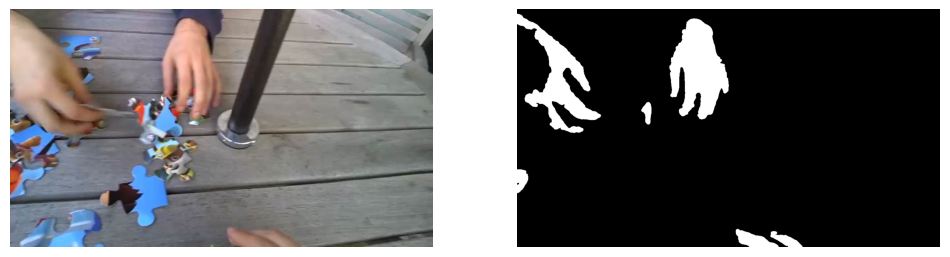

In [301]:
# Testing of final candidates
frame_name = labelled_frames[14]['frame']
img = cv2.imread(f'images/{frame_name}.jpg')
segmented_img = segment_hand_posturize_contours(img)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img[:,:,::-1])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_img, cmap='gray')
plt.axis('off')

plt.show()

# Accuracy evaluation

In [272]:
def evaluate_iou(segmented_imgs, ground_truth_imgs):
  total_intersection_area = 0
  total_union_area = 0
  for si, gti in zip(segmented_imgs, ground_truth_imgs):
    intersection = cv2.bitwise_and(si, gti)
    union = cv2.bitwise_or(si, gti)

    total_intersection_area += np.sum(intersection)
    total_union_area += np.sum(union)

  return total_intersection_area / total_union_area if total_union_area > 0 else 0

# Evaluation

20


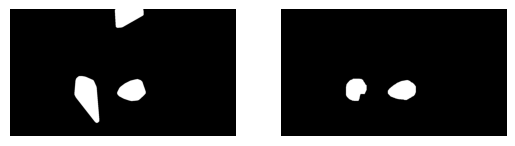

color_based acccuracy is:  0.6466105502136258
k means based accuracy is  0.3660826343098114


In [303]:

color_segmented_images = []
ground_truth_images = []
kmeans_images = []

print(len(frames))
lower_bound_HSV = np.array([6, 63, 47])
upper_bound_HSV = np.array([11, 146, 254])

for img_name in frames[:20]:
  img = cv2.imread(f'images/{img_name}.jpg')
  segmented_img1 = (segment_hand_color_contours(img, lower_bound=lower_bound_HSV, upper_bound=upper_bound_HSV, merge=True, merge_dist=150, ksize=(11, 11)) / 255).astype(np.uint8)
  color_segmented_images.append(segmented_img1)

  segmented_img2 = (segment_hand_posturize_contours(img, lower_bound=lower_bound_HSV, upper_bound=upper_bound_HSV, use_descriptors=True, color_space=cv2.COLOR_BGR2HSV, k_size=(11, 11)) / 255).astype(np.uint8)
  kmeans_images.append(segmented_img2)

  frame = get_labelled_frame(img_name)
  mask = get_segmentation_mask(frame)
  binary_overlay = np.zeros(mask.shape, dtype=np.uint8)
  binary_overlay[mask == 255] = 1
  ground_truth_images.append(binary_overlay)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(color_segmented_images[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_images[0], cmap='gray')
plt.axis('off')

plt.show()


print('color_based acccuracy is: ', evaluate_iou(color_segmented_images, ground_truth_images))
print('k means based accuracy is ', evaluate_iou(kmeans_images, ground_truth_images))
